In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dataclasses import dataclass

import pandas as pd
import scipy
import scipy.stats
import numpy as np

import price_time_series
from amm import AMM, Option, black_scholes
from users import RandomUser, TraderUser

In [4]:
%matplotlib inline

# Simulation is focused on performance of liquidity pool
There are some simplifications, like:
- using only one maturity.
- traders are quite simple.
- trading is split into "epochs", where each trader trades with some probability.
- you can imagine each epoch as being 1 hour and 1_000 epochs used here are hence cca 42 days. And the number of trades happening per hour (cca 2.7 trades, look at the end statistics). The price movements are quite high so the token would have be very volatile. Or you can imagine one epoch happening roughly every 9 hours so 1_000 epochs is one year with 2.7 trades happening every 9 hours.
- Each trade has size 1 base token (for eth/usdc it would be eth).
- Some of the traders observe the true volatility behind the process.

The price processed is modeled with moving volatility.

In [5]:
EPOCHS = 1_000

ALPHA = 0.3
BETA = 0.1

In [6]:
price, volatility = price_time_series.generate_price_volatility_process(
    alpha = ALPHA,
    beta = BETA,
    series_len = EPOCHS + 100
)
# the first observations are cut to have the series relatively stable
price, volatility = price[100:], volatility[100:]

<AxesSubplot:>

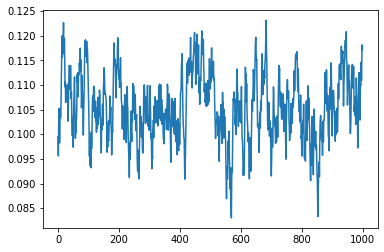

In [7]:
pd.Series(volatility).plot()

<AxesSubplot:>

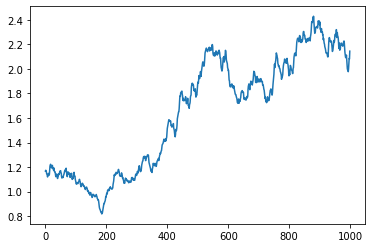

In [8]:
pd.Series(price).plot()

# Set up

## Liquidity pool

- for simplicity there is only one maturity and it expires at the end of the time series
- the pool(s) allows for both put and call and also for buying and selling
- there is only one instrument hence one pool for call option and one for put option

## AMM


## Traders

- traders have unlimited capital -> their capital and profit/loss is not measured
- all traders trade the same amount, equal to 1 token
- at each round users are shuffled

### There are 3 arbitragers

- first sees the volatility that generated the process and believes that it should be 10% lower
- second sees the volatility that generated the process and believes it is the true one
- third sees the volatility that generated the process and believes that it should be 10% higher

Each arbitrager executes its trade based on probability given by:

- for short (underwriting) -> (pool_premia - arbitragers_premia) / arbitragers_premia
- for long -> (arbitragers_premia - pool_premia) / arbitragers_premia

where
- arbitragers_premia is calculated by the volatility that the arbitrager believes is true
- pool_premia is adjusted for fees

### There is a random trader

- Trader that trades option with some probability.

# Simple simulation

In [9]:
# Set up
time_till_maturity_start=EPOCHS
amm = AMM(time_till_maturity=time_till_maturity_start, current_underlying_price=1.)
random_user = RandomUser(trade_probability=0.6, put_strikes=amm.put_strikes, call_strikes=amm.call_strikes)
trader_user_1 = TraderUser(amm=amm,volatility_adjustment=-0.1)
trader_user_2 = TraderUser(amm=amm,volatility_adjustment=0.)
trader_user_3 = TraderUser(amm=amm,volatility_adjustment=0.1)
users = [
    random_user,
    trader_user_1,
    trader_user_2,
    trader_user_3
]

In [10]:
for current_price, current_volatility, time_till_maturity in zip(price, volatility, range(time_till_maturity_start, 0, -1)):
    amm.next_epoch(time_till_maturity=time_till_maturity, current_underlying_price=current_price)
    
    # in each epoch the users are randomly ordered
    np.random.shuffle(users)
    for user in users:
        trade = user.trade(current_price, current_volatility)
        if trade is not None:
            amm.trade(
                strike_price=trade['strike_price'],
                type_=trade['type_'],
                long_short=trade['long_short'],
                quantity=trade['quantity']
            )
amm.next_epoch(time_till_maturity=0., current_underlying_price=price[-1])

/home/marek/Carmine_projects/option_amm_simulations/simulations/users.py:91: RuntimeWarning: invalid value encountered in double_scalars
  profitability = (amm_premia - trader_premia) / trader_premia
/home/marek/Carmine_projects/option_amm_simulations/simulations/users.py:91: RuntimeWarning: divide by zero encountered in double_scalars
  profitability = (amm_premia - trader_premia) / trader_premia


In [11]:
amm.clear()

In [12]:
amm.__dict__()

{'call_strikes': [1.7, 1.4, 1.2, 1.0, 0.9, 1.8, 1.5, 1.3, 1.6, 1.9, 1.1],
 'put_strikes': [1.1, 0.4, 0.8, 0.2, 0.3, 0.7, 1.0, 0.9, 0.6, 0.5],
 'call_volatility': 0.11212955159492112,
 'put_volatility': 0.11752278373539232,
 'call_pool_size': 118.38285958082506,
 'put_pool_size': 116.96548254428522,
 'call_issued_options': [],
 'put_issued_options': [],
 'time_till_maturity': 0.0,
 'current_underlying_price': 2.1447560656323668}

# Monte Carlo Simulation

In [13]:
# Epoch is a time step in the simulation
EPOCHS = 1_000

ALPHA = 0.3
BETA = 0.1

# Round is 1 run of the simulation
ROUNDS = 100

In [14]:
final_call_pool_sizes = []
final_put_pool_sizes = []
total_volumes = {'call': [], 'put': []}

In [17]:
for i in range(ROUNDS):
    print(f'Current round is {i}')
    price, volatility = price_time_series.generate_price_volatility_process(
        alpha = ALPHA,
        beta = BETA,
        series_len = EPOCHS + 100
    )
    price, volatility = price[100:], volatility[100:]
    time_till_maturity_start=EPOCHS
    amm = AMM(time_till_maturity=time_till_maturity_start, current_underlying_price=1.)
    
    random_user = RandomUser(trade_probability=0.6, put_strikes=amm.put_strikes, call_strikes=amm.call_strikes)
    trader_user_1 = TraderUser(amm=amm,volatility_adjustment=-0.1)
    trader_user_2 = TraderUser(amm=amm,volatility_adjustment=0.)
    trader_user_3 = TraderUser(amm=amm,volatility_adjustment=0.1)
    users = [
        random_user,
        trader_user_1,
        trader_user_2,
        trader_user_3
    ]
    
    total_volume = {'call': 0., 'put': 0.}
    
    for current_price, current_volatility, time_till_maturity in zip(price, volatility, range(time_till_maturity_start, 0, -1)):
        amm.next_epoch(time_till_maturity=time_till_maturity, current_underlying_price=current_price)

        # in each epoch the users are randomly ordered
        np.random.shuffle(users)
        for user in users:
            trade = user.trade(current_price, current_volatility)
            if trade is not None:
                amm.trade(
                    strike_price=trade['strike_price'],
                    type_=trade['type_'],
                    long_short=trade['long_short'],
                    quantity=trade['quantity']
                )
                total_volume[trade['type_']] += trade['quantity'] if trade['type_'] == 'call' else trade['quantity']
    amm.next_epoch(time_till_maturity=0., current_underlying_price=price[-1])
    amm.clear()
    final_call_pool_sizes.append(amm.call_pool_size)
    final_put_pool_sizes.append(amm.put_pool_size)
    total_volumes['call'].append(total_volume['call'])
    total_volumes['put'].append(total_volume['put'])

Current round is 0
Current round is 1
Current round is 2
Current round is 3
Current round is 4
Current round is 5
Current round is 6
Current round is 7
Current round is 8
Current round is 9
Current round is 10
Current round is 11
Current round is 12
Current round is 13
Current round is 14
Current round is 15
Current round is 16
Current round is 17
Current round is 18
Current round is 19
Current round is 20
Current round is 21
Current round is 22
Current round is 23
Current round is 24
Current round is 25
Current round is 26
Current round is 27
Current round is 28
Current round is 29
Current round is 30
Current round is 31
Current round is 32
Current round is 33
Current round is 34
Current round is 35
Current round is 36
Current round is 37
Current round is 38
Current round is 39
Current round is 40
Current round is 41
Current round is 42
Current round is 43
Current round is 44
Current round is 45
Current round is 46
Current round is 47
Current round is 48
Current round is 49
Current ro

In [18]:
print('Final call pool sizes (initial are 100)')
print('mean:', np.mean(final_call_pool_sizes))
print('min:', np.min(final_call_pool_sizes))
print('5th percentile:', np.percentile(final_call_pool_sizes, 5))
print('95th percentile:', np.percentile(final_call_pool_sizes, 95))
print('max:', np.max(final_call_pool_sizes))
print('mean total volume (trades) per round per epoch:', np.mean(total_volumes['call']) / EPOCHS)
print()
print('Final put pool sizes (initial are 100)')
print('mean:', np.mean(final_put_pool_sizes))
print('min:', np.min(final_put_pool_sizes))
print('5th percentile:', np.percentile(final_put_pool_sizes, 5))
print('95th percentile:', np.percentile(final_put_pool_sizes, 95))
print('max:', np.max(final_put_pool_sizes))
print('mean total volume (trades) per round per epoch:', np.mean(total_volumes['put']) / EPOCHS)

final_call_pool_sizes
mean: 122.77921183795041
min: 111.25991061235267
5th percentile: 117.61992157803695
95th percentile: 126.95972427921002
max: 132.31724630736602
mean total volume (trades) per round per epoch: 1.32907

final_put_pool_sizes
mean: 120.0324111298444
min: 103.1244583519342
5th percentile: 110.25732748232355
95th percentile: 131.94003227041105
max: 147.31409647767705
mean total volume (trades) per round per epoch: 1.366145
